@author: SteveEckel

This example covers calculating the textbook example of forces in a one-dimensional MOT with an $F=0\rightarrow F'=1$ atom.

There are three different governing equations that we can use for this example: the `heuristic` equation, the `rateeq` or the `obe`.  In this example, we'll calculate using all three and compare.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp
from pylcp.atom import atom
import scipy.constants as cts

### Let's now set up the units:

Whatever units we use, let's run numbers that are realistic for a common atom, Rb.:

In [8]:
rb87 = atom('87Rb')

klab = 2*np.pi*rb87.transition[1].k # Lab wavevector (without 2pi) in cm^{-1}
taulab = rb87.state[2].tau  # Lifetime of 6P_{3/2} state (in seconds)
gammalab = 1/taulab 
Blab = 15 # About 15 G/cm is a typical gradient for Rb

print(klab, taulab, gammalab/2/np.pi)

80528.75481555492 2.62348e-08 6066558.277246076


As with any problem in `pylcp`, the units that one chooses are arbitrary.  We will denote all explicit units with a subscript and all quantities where we have removed the units with an overbar, e.g. $\bar{x} = x/x_0$.  Our choice in this script will be different from the default choices of $x_0=1/k$ and $t_0 =1/\Gamma$.  Let's try a system where lengths are measured in terms of $x_0 = \hbar\Gamma/\mu_B B'$ and $t_0 = k x_0/\Gamma$.  This unit system has the advantage that it measures lengths in terms of Zeeman detuning in the trap.  Moreover, velocities are measured in $\Gamma/k$.  Namely,

$$
v = \bar{v} \frac{x_0}{t_0} = \bar{v} \frac{\Gamma}{k}
$$

From the documentation, the consistent mass scale is

$$
\bar{m} = m\frac{x_0^2}{\hbar t_0}
$$

In [9]:
# Now, here are our `natural' length and time scales:
x0 = cts.hbar*gammalab/(cts.value('Bohr magneton')*1e-4*15) # cm
t0 = klab*x0*taulab # s
mass = 87*cts.value('atomic mass constant')*(x0*1e-2)**2/cts.hbar/t0

# And now our wavevector, decay rate, and magnetic field gradient in these units:
k = klab*x0
gamma = gammalab*t0
alpha = 1.0*gamma     # The magnetic field gradient parameter

print(x0, t0, mass, k, gamma, alpha)

0.28896123233790394 0.0006104756167800681 18737128.19976159 23269.688230139665 23269.688230139665 23269.688230139665


Alternatively, we can just use the default unit system:

In [ ]:
# Now, here are our `natural' length and time scales:
x0 = 1/klab  # cm
t0 = taulab  # s

mass = 87*cts.value('atomic mass constant')*(x0*1e-2)**2/cts.hbar/t0

# And now our wavevector, decay rate, and magnetic field gradient in these units:
k = klab*x0
gamma = gammalab*t0
alpha = cts.value('Bohr magneton')*1e-4*15*x0*t0/cts.hbar

print(x0, t0, mass, k, gamma, alpha)

It turns out there is another choice of units, useful in the next example, 
that works extremely well if the radiative force is the *only* force.

### Define the problem

One has to define the Hamiltonian, laser beams, and magnetic field.

In [11]:
# Define the atomic Hamiltonian:
Hg, mugq = pylcp.hamiltonians.singleF(F=0, muB=1)
He, mueq = pylcp.hamiltonians.singleF(F=1, muB=1)

dijq = pylcp.hamiltonians.dqij_two_bare_hyperfine(0, 1)

ham = pylcp.hamiltonian(Hg, He, mugq, mueq, dijq, mass=mass, gamma=gamma, k=k)

det = -4.
beta = 1.5

# Define the laser beams:
laserBeams = pylcp.laserBeams(
    [{'kvec':k*np.array([1., 0., 0.]), 'beta': beta, 'pol':-1, 'delta':det*gamma},
     {'kvec':k*np.array([-1., 0., 0.]), 'beta': beta, 'pol':-1, 'delta':det*gamma}],
    beam_type=pylcp.infinitePlaneWaveBeam
)

# Define the magnetic field:
linGrad = pylcp.magField(lambda R: -alpha*R)

### Let's define the rate equations and heuristic equation

We'll add in the OBEs in a later example.

In [12]:
rateeq = pylcp.rateeq(laserBeams, linGrad, ham, include_mag_forces=True)
heuristiceq = pylcp.heuristiceq(laserBeams, linGrad, gamma=gamma, k=k, mass=mass)

Let's define a coordinate system and calculate the forces.

In [13]:
x = np.arange(-30, 30, 0.4)/(alpha/gamma)
v = np.arange(-30, 30, 0.4)

X, V = np.meshgrid(x, v)

Rvec = np.array([X, np.zeros(X.shape), np.zeros(X.shape)])
Vvec = np.array([V, np.zeros(V.shape), np.zeros(V.shape)])

rateeq.generate_force_profile(Rvec, Vvec, name='Fx', progress_bar=True)
heuristiceq.generate_force_profile(Rvec, Vvec, name='Fx', progress_bar=True)

Completed in 14.91 s.                                               
Completed in 5.35 s.                                               


Now let's plot it up.  No matter what unit system we use above, we want to measure lengths in terms of the magnetic field.  Dividing by the field gradient is enough to accomplish that:

Text(0, 0.5, '$v/(\\Gamma/k)$')

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


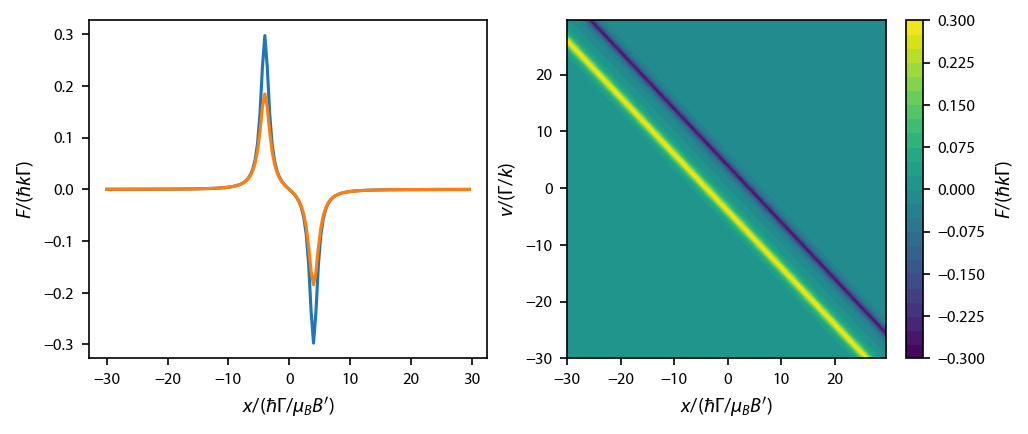

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, num="Expression", figsize=(6.5, 2.75))

ax[0].plot(x*(alpha/gamma), rateeq.profile['Fx'].F[0, int(np.ceil(x.shape[0]/2)), :]/gamma/k)
ax[0].plot(x*(alpha/gamma), heuristiceq.profile['Fx'].F[0, int(np.ceil(x.shape[0]/2)), :]/gamma/k)
ax[0].set_ylabel('$F/(\hbar k \Gamma)$')
ax[0].set_xlabel('$x/(\hbar \Gamma/\mu_B B\')$')

im1 = ax[1].contourf(X*(alpha/gamma), V, rateeq.profile['Fx'].F[0]/gamma/k, 25)
fig.subplots_adjust(left=0.08, wspace=0.2)
cb1 = plt.colorbar(im1)
cb1.set_label('$F/(\hbar k \Gamma)$')
ax[1].set_xlabel('$x/(\hbar \Gamma/\mu_B B\')$')
ax[1].set_ylabel('$v/(\Gamma/k)$')


Note that heuristic equation produces less force at resonance in $x$, because it is over-estimating the total saturation.

### Compute the trap frequencies and damping rates

And we can compare to simple 1D theory.

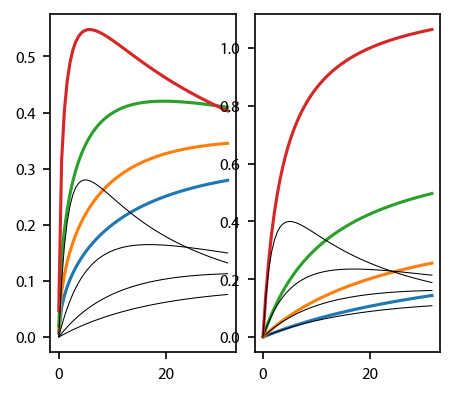

In [5]:
dets = np.array([-4., -3., -2., -1.])
betas = np.linspace(0.01, 10**1.5 , 61)

omegasqrd = np.zeros(betas.shape + dets.shape)
dampingcoeff = np.zeros(betas.shape + dets.shape)

omegasqrd_simple = np.zeros(betas.shape + dets.shape)
dampingcoeff_simple = np.zeros(betas.shape + dets.shape)

for ii, det in enumerate(dets):
    for jj, beta in enumerate(betas):
        # Define the laser beams:
        laserBeams = [None]*2
        laserBeams[0] = pylcp.laserBeam(kvec=np.array([1., 0., 0.]), beta=beta, pol=-1,
                                        delta=det)
        laserBeams[1] = pylcp.laserBeam(kvec=np.array([-1., 0., 0.]), beta=beta, pol=-1,
                                        delta=det)

        # Luckily, we know exactly where the center of the MOT is, so we don't
        # need to find it first.  (A must in non-symmetric geometries).
        DerVec = np.array([[-0.0001,0.0001],[0.0, 0.0,],[0.0, 0.0]])
        StatVec = np.array([[1e-9, 1e-9],[0.0, 0.0,],[0.0, 0.0]])

        trap = pylcp.trap_rateeq(laserBeams, linGrad, ham, include_mag_forces=False)
        omegasqrd[jj, ii] = trap.trapping_frequencies(axes=[0], eps=0.0002)
        dampingcoeff[jj, ii] = trap.damping_coeff(axes=[0], eps=0.0002)

fig, ax = plt.subplots(1,2)
for ii, det in enumerate(dets):
    ax[0].plot(betas, omegasqrd[:, ii], '-', color='C{0:d}'.format(ii))
    ax[0].plot(betas, -8*0.7*det*betas/(1 + betas + 4*det**2)**2, 'k-', linewidth=0.5)
    ax[1].plot(betas, dampingcoeff[:, ii], '-', color='C{0:d}'.format(ii))
    ax[1].plot(betas, -8*det*betas/(1 + betas + 4*det**2)**2, 'k-', linewidth=0.5)